# Using neural networks to parameterize advection in L96

In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from L96_model import (
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)
from matplotlib.animation import FuncAnimation

time_method = RK4

# Introduction

We are only going to use the single equation model from [Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved), or equation 3.1:
\begin{align}
\frac{d}{dt} X_k
= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F
\end{align}

The reason we do this is because the advection term has a much larger control on the stability of the system than the scale-interaction term.  It is fairly difficult to learn a model for the sub-grid scale term that causes L96 to go unstable so long as the timestep is sufficient to keep the advection term stable.

We still want to to look into the stability of a learned parameterization, but to explore the stability in more detail we are going to focus on learning a neural-network for the advection.

## Building a 1d and 2d version of the single-equation L96 model:

The '1d' in time, or advectionless version of L96 reduces to:
\begin{align}
\frac{d}{dt} X_k
= - X_k + F,
\end{align}
the steady state solution is simply:

\begin{align}
X_k=F,
\end{align}

and the time-dependent solution is an exponential:

\begin{align}
X_k
= \left(F- (F-X_k^0)\exp(-t) \right).
\end{align}


We are going to generate both 2d (w/ advection) and 1d (w/o advection) versions of the L96 model.  The 2d model will then be used as training data to build a non-local neural network that can reproduce the effect of including the advection term.



In [2]:
# - This is a standard GCM class including a polynomial parameterization in rhs of equation for tendency.
#  In this experiment we will not be using the parameterization in this class but have left it for generality.
class GCM:
    def __init__(self, F, parameterization, time_stepping=RK4):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) + self.parameterization(param, X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [3]:
# - This is the same as the GCM with one notable exception.
#  We have set the advection flag to False in the RHS of the L96 equation.
class GCM_1d:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F, advect=False) + self.parameterization(
            param, X, self.F
        )

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

## Sample configuration

First we will run the 2d and 1d version of the model with a modest forcing of $F=10$.

We are going to try to simulate the effect of climate model drift on parameter space by running the same model but with $F=20$.

In [4]:
# Chose a modest forcing and simulate for 100 cycles
Forcing, dt, T = 10, 0.01, 100
Forcing_x10 = 20  # Forcing*10

# Choose an random set of initial conditions
b = 10
init_cond = b * np.random.randn(8)

# ----------------------------------------------------------------
# We create the template 2d GCM here with the polynomial parameterization
# this model will be used to generate training data to learn the advection term.
naive_parameterization = lambda param, X, F: np.polyval(param, X)
gcm_2d = GCM(Forcing, naive_parameterization)

# ----------------------------------------------------------------
# We also create a super GCM for simulation with the forcing of 100.
# This will be used as the truth when we test the ability of the 1d model with the neural network to
# work outside of the parmameter space it was trained.
gcm_2d_x10 = GCM(Forcing_x10, naive_parameterization)

# ----------------------------------------------------------------
# Finally,we build the 1d GCM including the polynomial parameterization,
# and we create the corresponding super GCM with forcing squared.
gcm_1d = GCM_1d(Forcing, naive_parameterization)
gcm_1d_x10 = GCM_1d(Forcing_x10, naive_parameterization)

In [5]:
# Running the 2d and 1d versions of the GCM and GCM with F=100 ("_x10")

x2d, t2d = gcm_2d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x2d_x10, t2d_x10 = gcm_2d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

x1d, t1d = gcm_1d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x1d_x10, t1d_x10 = gcm_1d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

## Metrics:

We are going to track the momentum and energy of L96 via the following metrics:

#### Momentum:
\begin{align}
p = \sum_k X_k
\end{align}


#### Energy:
\begin{align}
e = \sum_k X_k^2
\end{align}


These metrics are chosen to track the system.  We are looking for a conservative property of the L96 system.  It turns out in the single equation form of the L96 problem one of these two metrics is conserved by the advection process, which is the energy like term.


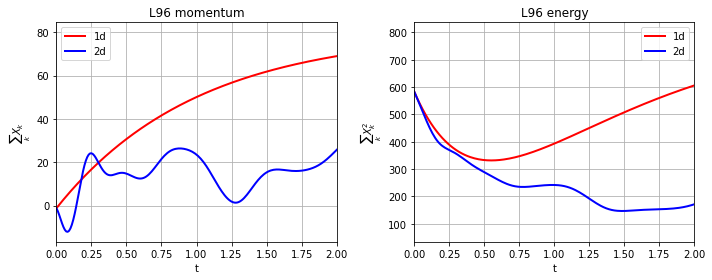

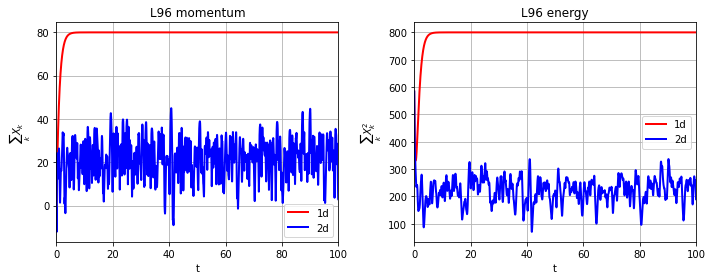

In [6]:
for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(t1d, np.sum(x1d, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(t1d, np.sum(x1d**2, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

# Demo: Conservation of energy in L96

To demonstrate the conservation of energy in L96 advection we build a model with 0 forcing and 0 damping.

Note that the cyan line is an experiment only undergoing forcing by the advection term.  The momentum is clearly not conserved, but the energy is.


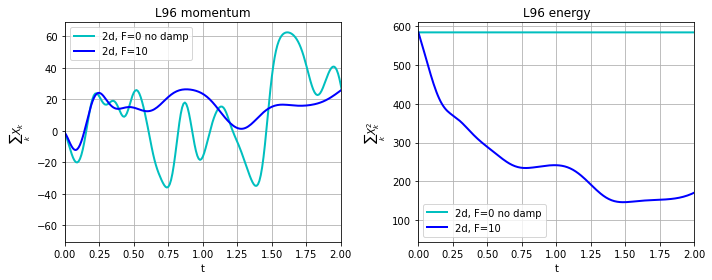

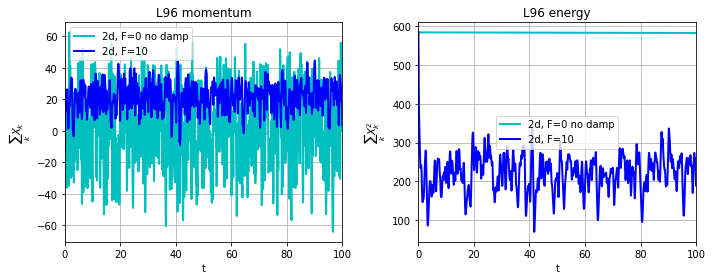

In [7]:
# Zero the forcing
Forcing_demo = 0
# Zero the damping via a linear parameterization term:
P_nodamp = [1.0, 0.0]

# Running the 2d and 1d versions of the GCM and GCM with squared forcing ("s")

gcm_2d_demo = GCM(Forcing_demo, naive_parameterization)
# The parameterization here is countering the decay term to demonstrate the conservation of this system
x2d_demo, t2d_demo = gcm_2d_demo(init_cond, dt, int(T / dt), P_nodamp)


for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo**2, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

# Building a dataset of advection tendencies to learn

In the next section we are going to create a dataset of advection tendencies to learn

In [8]:
# The first set of data to learn is built with the standard forcing

obs = gcm_2d
model = gcm_1d

N = 50000

X = []
Xm1 = []
Xm2 = []
Xp1 = []
Adv = []

# randomize the initial condition and run 1000 time-step spin up with the real world model
init_condr = 10 * np.random.randn(8)
x_2, _ = gcm_2d(
    init_condr,
    0.01,
    1000,
    [
        0.0,
    ],
)

for ti in range(N):

    # Set the initial condition from the spin up/2d model
    init_condr_up = x_2[-1, :]

    # Real world values
    x_2, _ = obs(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )
    # Simple model values
    x_1, _ = model(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )

    # This is the difference in the tendency term due to neglecting 2d processes per time-step
    Adv.append((x_2[-1, :] - x_1[-1, :]).ravel() / dt)

    # Storing the state variable and its rolled forms for plotting and learning convenience
    X.append(x_1[-1, :].ravel())
    Xm1.append(np.roll(x_1[-1, :], 1).ravel())
    Xm2.append(np.roll(x_1[-1, :], 2).ravel())
    Xp1.append(np.roll(x_1[-1, :], -1).ravel())

X = np.array(X)
Xm1 = np.array(Xm1)
Xm2 = np.array(Xm2)
Xp1 = np.array(Xp1)
Adv = np.array(Adv)

In [9]:
# We use a second set of learning data with the F=20 forcing

obs = gcm_2d_x10
model = gcm_1d_x10

N = 50000

X_x10 = []
Xm1_x10 = []
Xm2_x10 = []
Xp1_x10 = []
Adv_x10 = []

# randomize the initial condition and run 1000 time-step spin up with the real world model
init_condr = 10 * np.random.randn(8)
x_2, _ = gcm_2d(
    init_condr,
    0.01,
    1000,
    [
        0.0,
    ],
)

for ti in range(N):

    # Set the initial condition from the spin up/2d model
    init_condr_up = x_2[-1, :]

    # Real world values
    x_2, _ = obs(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )
    # Simple model values
    x_1, _ = model(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )

    # This is the difference in the tendency term due to neglecting 2d processes per time-step
    Adv_x10.append((x_2[-1, :] - x_1[-1, :]).ravel() / dt)

    # Storing the state variable and its rolled forms for plotting and learning convenience
    X_x10.append(x_1[-1, :].ravel())
    Xm1_x10.append(np.roll(x_1[-1, :], 1).ravel())
    Xm2_x10.append(np.roll(x_1[-1, :], 2).ravel())
    Xp1_x10.append(np.roll(x_1[-1, :], -1).ravel())

X_x10 = np.array(X_x10)
Xm1_x10 = np.array(Xm1_x10)
Xm2_x10 = np.array(Xm2_x10)
Xp1_x10 = np.array(Xp1_x10)
Adv_x10 = np.array(Adv_x10)

# Choosing a parameter to parameterize from

If we were simply looking at data and knew that the advection term was a missing force, we might start by looking at correlations with $X_k$ values, but we would quickly relize that this is not effective.

Even taking part of the actual advection term does not yield a useful feature parameter.

In principle we should be able to learn a parameterization with all combinations of polynomials including all $X_k$'s, which should yield something close to the right answer.  

Text(0, 0.5, 'Advection')

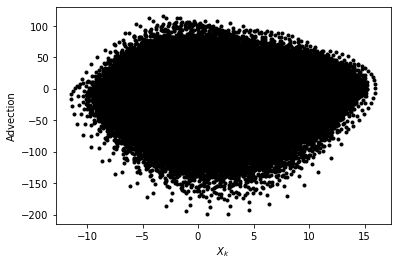

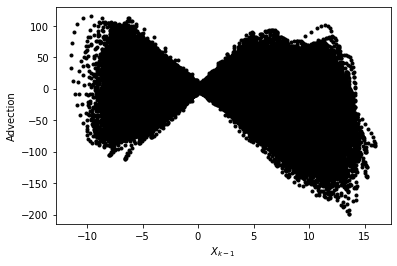

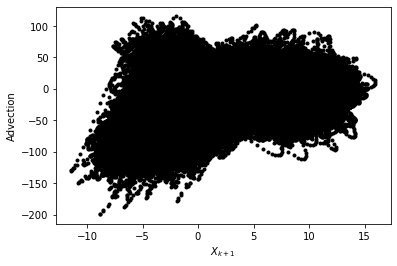

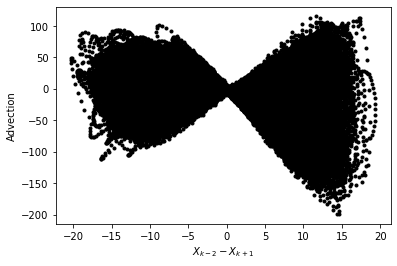

In [10]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_{k}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm1, Adv, "k.")
plt.xlabel("$X_{k-1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xp1, Adv, "k.")
plt.xlabel("$X_{k+1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm2 - Xp1, Adv, "k.")
plt.xlabel("$X_{k-2}-X_{k+1}$")
plt.ylabel("Advection")


Let's now just assume that we knew the form of the advection term.  We now get something that looks like a 1:1 linear relationship between the observed advection term and the correct feature parameter.  It is not perfect because the values we are using for $X_k$ are not consistent with the RK4 time stepping (if we used forward Euler we would get a perfit fit).

Fit (slope/bias):  [ 1.00360236 -0.08301991]


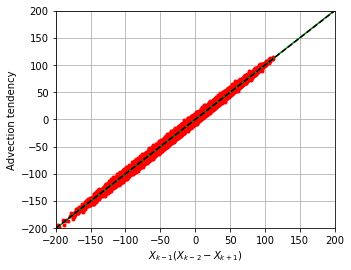

In [11]:
# We are going to assume we know the feature variable that we need to train the model.
# However, because of sampling across a time-step we will not fit a perfect 1:1,
# we end up with something very close to 1:1, but we will use a higher order polynomial that will
# fail when used outside the training data.

# First we will tune with the original F=10 output

plt.figure(figsize=(5, 4))
Feature = -Xm1 * (np.array(Xm2) - np.array(Xp1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$X_{k-1}(X_{k-2}-X_{k+1})$")
plt.ylabel("Advection tendency")

# This parameterization might fail when used outside of the training data.
# Note if we used the Forward Euler timestepping we would get closer to a 1:1 fit for the data.
P = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
print("Fit (slope/bias): ", P)
FS = [-200, 200]
plt.plot(FS, np.polyval(P, FS), "g-", label="polynomial parameterization")
plt.plot(FS, FS, "k--", label="1:1")
plt.xlim(FS)
plt.ylim(FS)
plt.grid(True)

In [12]:
# Create a new 1d GCM with a parameterization for the advection based on the known advection parameter
advection_parameterization = lambda param, X, F: np.polyval(
    param, -np.roll(X, 1) * (np.roll(X, 2) - np.roll(X, -1))
)
gcm_1d_padv = GCM_1d(Forcing, advection_parameterization)
gcm_1d_padv_x10 = GCM_1d(Forcing_x10, advection_parameterization)

# Here is the 1d GCM with the learned advection via the linear parameterization
xplinear, tplinear = gcm_1d_padv(init_cond, dt, int(T / dt), P)

# And the same 1d GCM applied out of sample
xplinear_x10, tplinear_x10 = gcm_1d_padv_x10(init_cond, dt, int(T / dt), P)

In [13]:
def CompExps(Exp1, ExpN):
    # Exp1 - reference experiment list
    # ExpN - list of comparison experiments

    try:
        T1 = Exp1[0]
        X1 = Exp1[1]
        L1 = Exp1[2]
        F, ax = plt.subplots(1, 2, figsize=(10, 4))
        a = ax.ravel()[0]
        a.plot(T1, np.sum(X1, axis=1), label=L1, color="k", linewidth=3)
        a = ax.ravel()[1]
        a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)

        F2, ax2 = plt.subplots(1, figsize=(5, 4))

        for Exp in ExpN:
            TN = Exp[0]
            XN = Exp[1]
            LN = Exp[2]

            a = ax.ravel()[0]
            a.plot(TN, np.sum(XN, axis=1), label=LN, linewidth=2)
            a = ax.ravel()[1]
            a.plot(TN, np.sum(XN**2, axis=1), label=LN, linewidth=2)

            _X = []
            _Y = []
            for ii in range(1, 100, 1):
                _X.append(np.percentile(np.sum(X1[int(5 // dt) :] ** 2, axis=1), ii))
                _Y.append(np.percentile(np.sum(XN[int(5 // dt) :] ** 2, axis=1), ii))
            ax2.plot(_X, _Y, ".-", label=LN)

        for ii in range(2):
            a = ax.ravel()[ii]
            a.legend()
            a.grid(True)
        ax[0].set(ylabel=r"$\sum_k X_k$", xlabel=r"$t$")
        ax[1].set(ylabel=r"$\sum_k X_k^2$", xlabel=r"$t$")
        F.tight_layout()

        ax2.grid(True)
        ax2.set(
            xlabel="e 2d model",
            ylabel="e 1d model w/ param",
            title="q-q plot of energy in 2d and parameterized model",
        )
        LIM = np.nanmax(list(_X) + list(_Y))
        ax2.set_xlim(0, LIM * 1.1)
        ax2.set_ylim(0, LIM * 1.1)
        ax2.plot([0, LIM], [0, LIM], "y-")
        pass
    except:
        pass

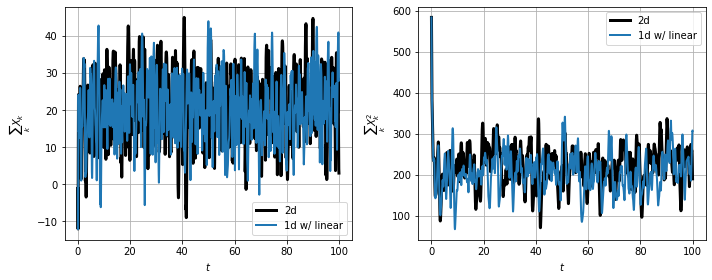

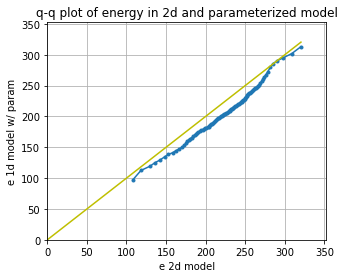

In [14]:
# This (should) learn a stable 'parameterization' for the advection that is very close to the real advection term.

CompExps(
    [t2d, x2d, "2d"],
    [
        [tplinear, xplinear, "1d w/ linear"],
    ],
)

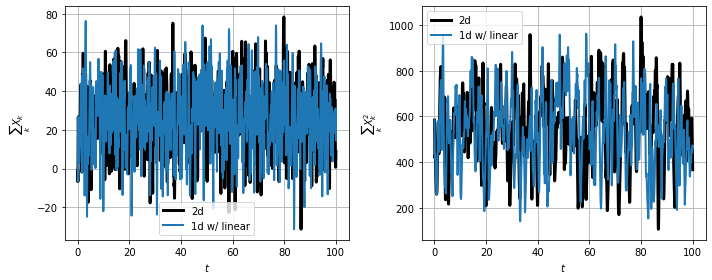

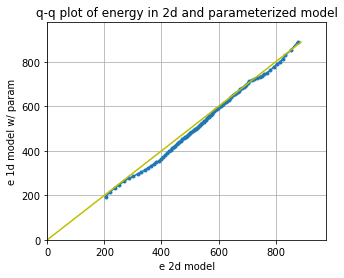

In [15]:
# It even extrapolates to the F=20 model

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tplinear_x10, xplinear_x10, "1d w/ linear"],
    ],
)

# What if we chose the wrong feature?

It turns out you can find features that are approximately correct and build a decent model for the advection


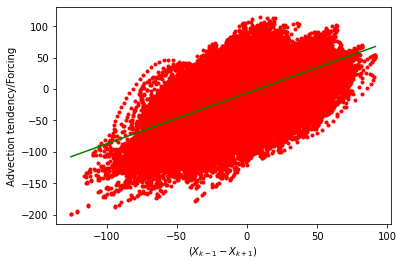

In [16]:
# Now we use a feature that is wrong to train the model

plt.figure()
Feature = -(np.array(Xm2) - np.array(Xp1) * np.array(Xm1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$(X_{k-1}-X_{k+1})$")
plt.ylabel("Advection tendency/Forcing")

P_wrong = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
FS = np.sort(np.array(Feature).ravel())
plt.plot(FS, np.polyval(P_wrong, FS), "g-", label="polynomial parameterization");

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in square


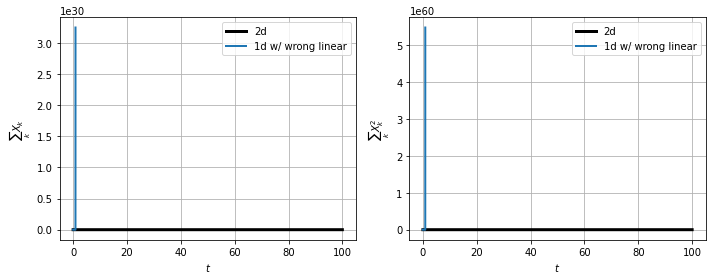

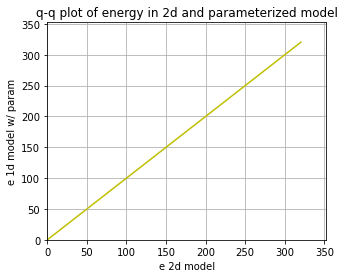

In [17]:
# Create a new 1d GCM with a 2d parameterization
advection_parameterization_wrong = lambda param, X, F: np.polyval(
    param, -(np.roll(X, 2) - np.roll(X, -1) * np.roll(X, 1))
)
gcm_1d_padv_wrong = GCM_1d(Forcing, advection_parameterization_wrong)

# Here is the 1d GCM with the learned advection
x_wrongp, t_wrongp = gcm_1d_padv_wrong(init_cond, dt, int(T / dt), P_wrong)

# This goes unstable very quickly.
# The neural network thus must be trained pretty well to avoid these instabilities.
CompExps(
    [t2d, x2d, "2d"],
    [
        [t_wrongp, x_wrongp, "1d w/ wrong linear"],
    ],
)

Using the wrong feature gave us a very unstable model with advection that does not work.

In the following, we will try to learn the advection from a neural network.  This result shows that we need to do something reasonable to have a stable system.

# Using the 3-layer non-local neural network

Now we can forget about neading to know the right form of the advection term.
We are instead just going to throw the information from the advection scheme to the non-local neural network and let it learn the advection for itself.



These follow the templates from the exercise led by Janni in week 4.



_I'm quite new to neural networks, so please let me know if you see any obvious mistakes in my approach!_

In [18]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

# I'm going to start by scaling the data so that it is approximately order 1.

It looks like we can scaling $X$ and the advection with the forcing and forcing squared, respectively (we will come back to this assumption).

Advection RMS: 28.943283840253493
X RMS: 5.155297561675968
Scaled Advection RMS: 0.2894328384025349
Scaled X RMS: 0.515529756167597
N training data:  40000
N testing data:  10000


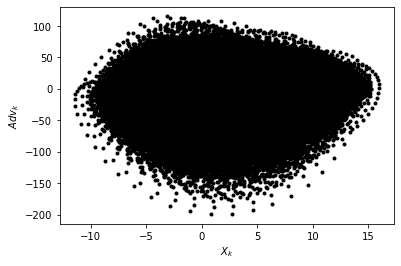

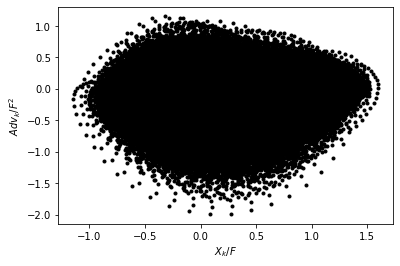

In [19]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_k$")
plt.ylabel("$Adv_k$")

# for F=10
X_F = X / Forcing
Adv_F = Adv / Forcing**2

print("Advection RMS:", np.sqrt(np.mean(Adv**2)))
print("X RMS:", np.sqrt(np.mean(X**2)))

plt.figure()
plt.plot(X_F, Adv_F, "k.")
plt.xlabel("$X_k/F$")
plt.ylabel("$Adv_k/F^2$")

print("Scaled Advection RMS:", np.sqrt(np.mean(Adv_F**2)))
print("Scaled X RMS:", np.sqrt(np.mean(X_F**2)))

# Split into 80% training and 20% testing.

L = int(len(X) * 0.8)

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[:L])).double(),
    torch.from_numpy(np.array(Adv_F[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


print("N training data: ", len(X_F[:L]))


print("N testing data: ", len(X_F[L:]))

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[L:])).double(),
    torch.from_numpy(np.array(Adv_F[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

In [20]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
        # self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [21]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss


criterion = torch.nn.MSELoss()  # MSE loss function

train loss: 0.02777355395171452
validation loss: 0.0279891076600364
train loss: 0.01764239073380081
validation loss: 0.018203123685100506
train loss: 0.015113905163785687
validation loss: 0.015604283696792717
train loss: 0.014077369132000356
validation loss: 0.014500784807791869
train loss: 0.012990841774726697
validation loss: 0.013377949900908053
train loss: 0.012688612865162045
validation loss: 0.013217279683617803
train loss: 0.01423629694500451
validation loss: 0.014842395783187589
train loss: 0.012289977905616013
validation loss: 0.012825561089047439
train loss: 0.011658215365344097
validation loss: 0.012154307859005082
train loss: 0.011958947650987482
validation loss: 0.012365101176235372
train loss: 0.012495174316283211
validation loss: 0.0131035386382685
train loss: 0.011927487623879383
validation loss: 0.01210781338909993
train loss: 0.01147602108639907
validation loss: 0.011753636555893851
train loss: 0.011714516850773812
validation loss: 0.01197100747052685
train loss: 0.01

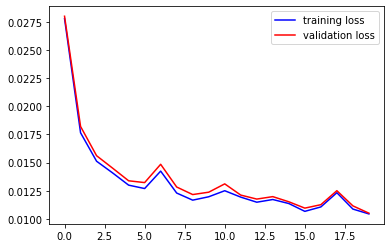

In [22]:
torch.manual_seed(14)  # For reproducibility
nn_3l = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.03)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

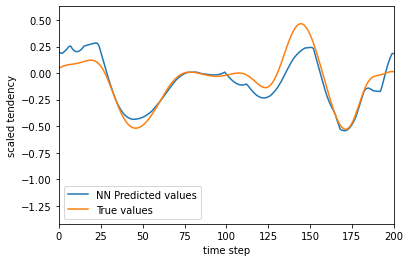

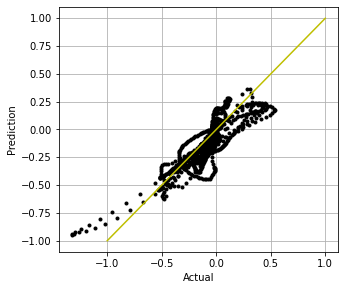

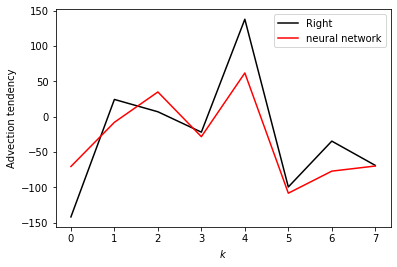

In [23]:
# Look how network does for the tendencies

preds22 = nn_3l(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * Forcing**2, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

In [24]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
# The advection will be set to False
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / self.F).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / self.F, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + self.F**2 * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [25]:
# Run a test with the parameterization
# It takes some time, but usually the network goes unstable eventually

# F=10 model
gcm_nn = GCM_network(Forcing, nn_3l)
xnn, tnn = gcm_nn(init_cond, dt, int(100 / (dt)), nn_3l)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn, xnn, "1d w/ neural network"],
    ],
)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in square
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in square
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/transforms.py:379: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

Advection RMS: 28.943283840253493
X RMS: 5.155297561675968
Scaled Advection RMS: 0.18830372177170668
Scaled X RMS: 0.40478530209136526
N training data:  40000
N testing data:  10000


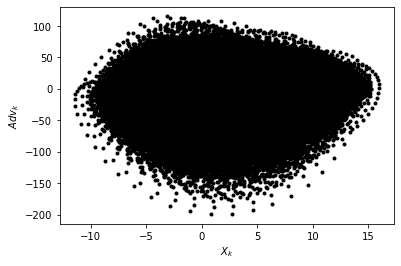

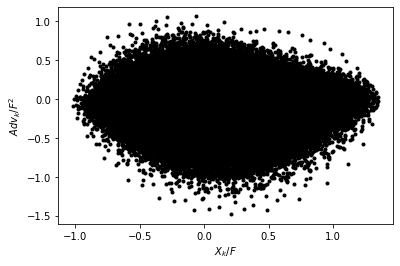

In [26]:
# Try to train the data with slightly higher forcing (will give larger range of advection tendencies to learn)

plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_k$")
plt.ylabel("$Adv_k$")

# for F=20
X_F = X_x10 / Forcing_x10
Adv_F = Adv_x10 / Forcing_x10**2

print("Advection RMS:", np.sqrt(np.mean(Adv**2)))
print("X RMS:", np.sqrt(np.mean(X**2)))

plt.figure()
plt.plot(X_F, Adv_F, "k.")
plt.xlabel("$X_k/F$")
plt.ylabel("$Adv_k/F^2$")

print("Scaled Advection RMS:", np.sqrt(np.mean(Adv_F**2)))
print("Scaled X RMS:", np.sqrt(np.mean(X_F**2)))

# Split into 80% training and 20% testing.

L = int(len(X) * 0.8)

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[:L])).double(),
    torch.from_numpy(np.array(Adv_F[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


print("N training data: ", len(X_F[:L]))


print("N testing data: ", len(X_F[L:]))

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[L:])).double(),
    torch.from_numpy(np.array(Adv_F[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

train loss: 0.015462832528459564
validation loss: 0.015339960384851175
train loss: 0.010157753527892789
validation loss: 0.010277498766411588
train loss: 0.008653605043873719
validation loss: 0.009152460156696646
train loss: 0.007199442859825276
validation loss: 0.007528631286301607
train loss: 0.007444048171926257
validation loss: 0.007572505002616357
train loss: 0.006370227666888234
validation loss: 0.006431162095855808
train loss: 0.005936309613348569
validation loss: 0.006071492654057554
train loss: 0.005958184115728822
validation loss: 0.006175485145221241
train loss: 0.005666100400577733
validation loss: 0.005867438905427802
train loss: 0.005416345544834206
validation loss: 0.005502717631384
train loss: 0.005601329270058986
validation loss: 0.0057357301437111746
train loss: 0.005178740164002787
validation loss: 0.005323235463131698
train loss: 0.005633968242915576
validation loss: 0.005753303938233248
train loss: 0.00625487269898424
validation loss: 0.006287003705305447
train los

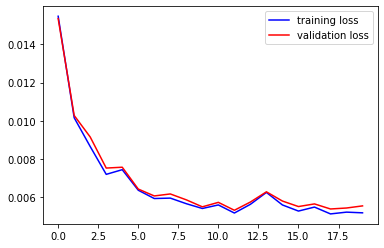

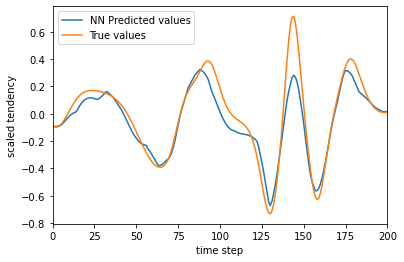

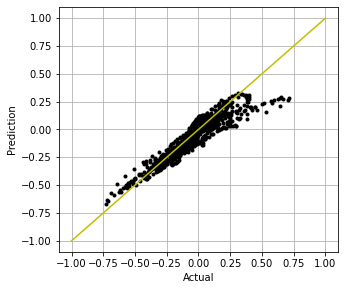

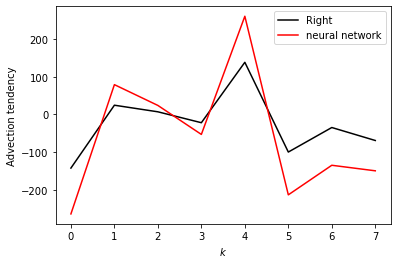

In [27]:
torch.manual_seed(14)  # For reproducibility
nn_3l_x10 = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_x10.parameters(), lr=0.03)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_x10, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_x10, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_x10, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend()

# Look how network does for the tendencies

preds22 = nn_3l_x10(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_x10(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * Forcing_x10**2, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

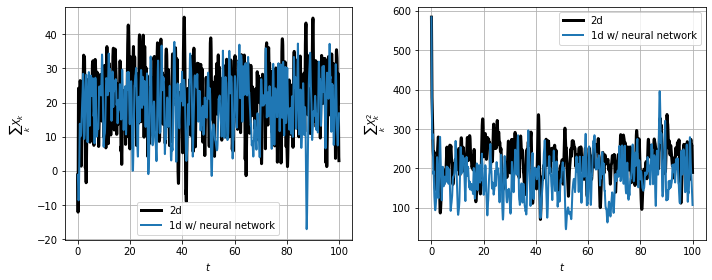

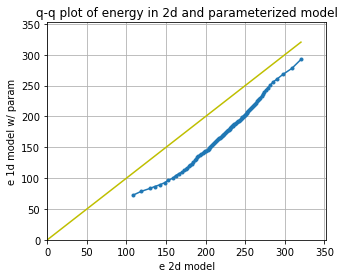

In [28]:
# Run a test with the parameterization built from F=20
# Usually the neural network resulting is much more stable, since it is trained for a wider range of conditions.

# F=10 model
gcm_nn = GCM_network(Forcing, nn_3l_x10)
xnn, tnn = gcm_nn(init_cond, dt, int(100 / (dt)), nn_3l_x10)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn, xnn, "1d w/ neural network"],
    ],
)

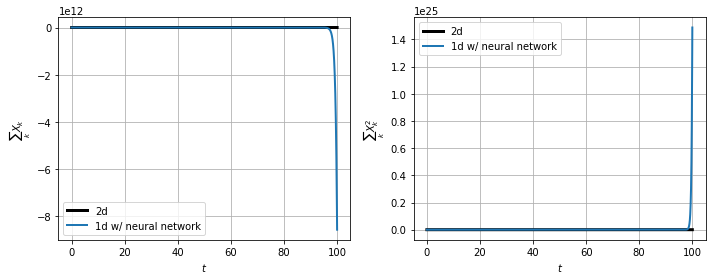

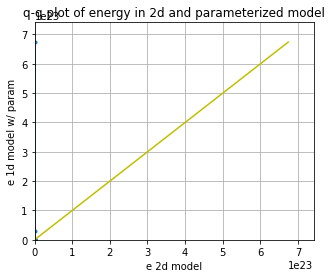

In [29]:
# F=20 model fails still
gcm_nn_x10 = GCM_network(Forcing_x10, nn_3l_x10)
xnn_x10, tnn_x10 = gcm_nn_x10(init_cond, dt, int(100 / (dt)), nn_3l_x10)

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn_x10, xnn_x10, "1d w/ neural network"],
    ],
)

# Here we experiment with adding conservation of "momentum"

- It turns out the L96 advection does not conserve momentum, but this exercise shows that we can build a parameterization that does by adding it to the loss function.

In [30]:
def my_loss2(inpt, output, target):
    # In which we add conservation of "momentum" to our loss function
    loss = torch.mean(2 * (output - target) ** 2) + torch.mean(
        torch.sum(output, axis=1) ** 2
    )
    return loss

In [31]:
# New training routines that use the new loss function


def train_model2(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(b_x, prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model2(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(b_x, prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss

In [32]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss2 = Net_ANN().double()

train loss: 0.06909479605157443
validation loss: 0.06720736030613414
train loss: 0.05999860035205264
validation loss: 0.058993476259072766
train loss: 0.052685979045785904
validation loss: 0.051632238472570605
train loss: 0.04374144912760344
validation loss: 0.04384356181810607
train loss: 0.0370319707943098
validation loss: 0.03733982457662049
train loss: 0.03322336895227877
validation loss: 0.03387386937137525
train loss: 0.03120019723038584
validation loss: 0.031948596912409664
train loss: 0.028298012061256976
validation loss: 0.029262358223236012
train loss: 0.026850455277636874
validation loss: 0.027921114442294875
train loss: 0.02586582491339425
validation loss: 0.026867473885846028
train loss: 0.025219272285831106
validation loss: 0.026153566859951884
train loss: 0.024140696500567962
validation loss: 0.025216812432819265
train loss: 0.024749296786151877
validation loss: 0.025525804121060917
train loss: 0.02349502612065281
validation loss: 0.024179914031577154
train loss: 0.02258

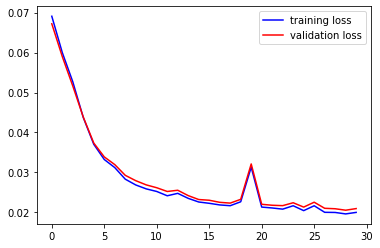

In [33]:
n_epochs = 30  # Number of epocs
optimizer = optim.Adam(nn_3l_loss2.parameters(), lr=0.02)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss2, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss2, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss2, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

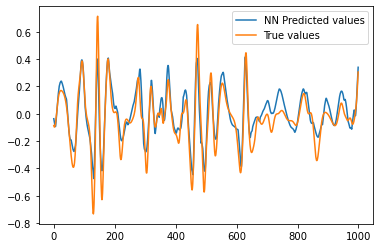

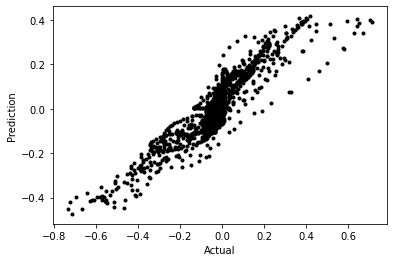

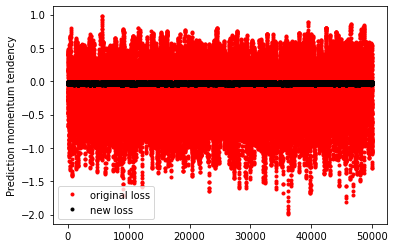

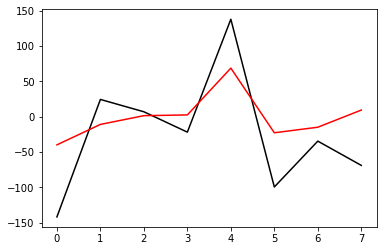

In [34]:
# The neural network now conserves momentum

preds22o = nn_3l(torch.from_numpy(np.array(X_F)).double())
preds22 = nn_3l_loss2(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1), "r.", label="original loss")
plt.plot(np.sum(preds22.detach().numpy(), axis=1), "k.", label="new loss")
plt.ylabel("Prediction momentum tendency")
plt.legend()

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss2(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

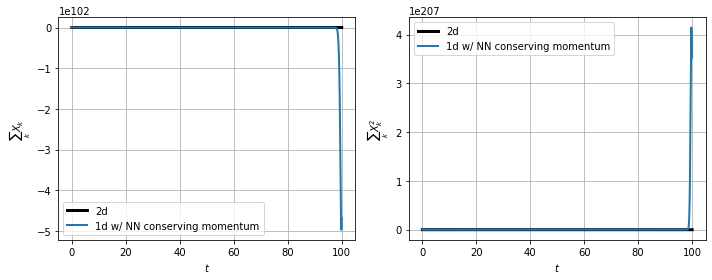

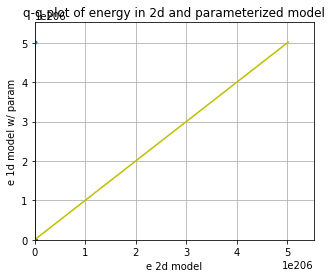

In [35]:
# This didn't help with stabilization...actually seems to hurt

gcm_nn2 = GCM_network(Forcing, nn_3l_loss2)
xnn2, tnn2 = gcm_nn2(init_cond, dt, int(T / (dt)), nn_3l_loss2)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn2, xnn2, "1d w/ NN conserving momentum"],
    ],
)

# How about with some regularization?

train loss: 0.02620146990977138
validation loss: 0.025762078921883154
train loss: 0.022432962358751855
validation loss: 0.02252320576131119
train loss: 0.019591253899408974
validation loss: 0.01971884420751227
train loss: 0.019194436502776663
validation loss: 0.019403345343244727
train loss: 0.01828251463918458
validation loss: 0.01843523263810066
train loss: 0.01687129653618161
validation loss: 0.0171507765770792
train loss: 0.016181436144251167
validation loss: 0.01641638033874922
train loss: 0.015968614310763067
validation loss: 0.0162114146488514
train loss: 0.015834384457823543
validation loss: 0.016098508687524625
train loss: 0.016243311261183883
validation loss: 0.016481538023210708
train loss: 0.014871883535559596
validation loss: 0.01510490966885306
train loss: 0.014700142659948758
validation loss: 0.014988877687939568
train loss: 0.015330178055912302
validation loss: 0.015532051484351017
train loss: 0.014636138502996762
validation loss: 0.014802964333787222
train loss: 0.0156

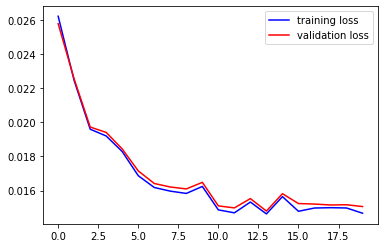

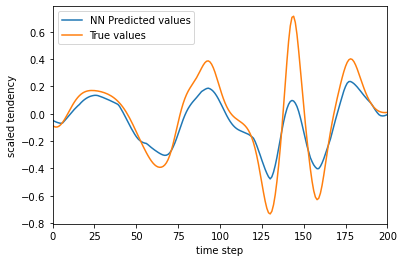

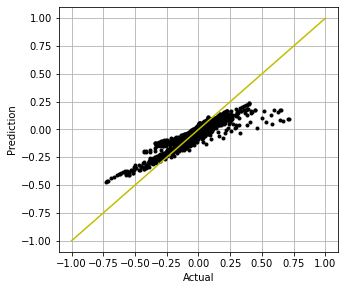

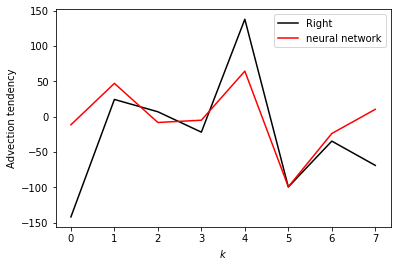

In [36]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss3 = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_loss3.parameters(), lr=0.03, weight_decay=0.0015)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_loss3, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_loss3, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_loss3, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend()

# Look how network does for the tendencies

preds22 = nn_3l_loss3(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = (
    nn_3l_loss3(torch.from_numpy(np.array(Xt / Forcing_x10)).double()).detach().numpy()
)

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * Forcing_x10**2, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

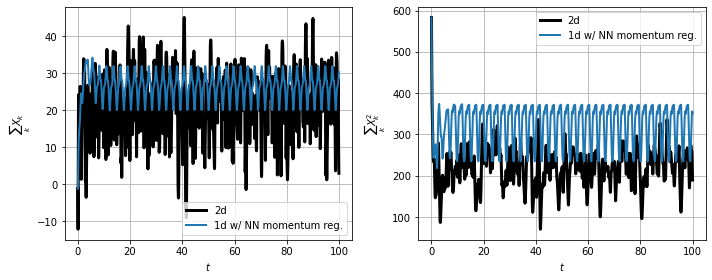

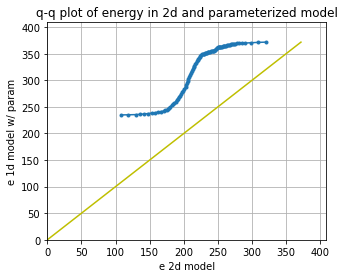

In [37]:
# Weight decay regularization can help with stability, but when it does it sometimes ruins the
# model representation of the actual 'physics'

gcm_nn3 = GCM_network(Forcing, nn_3l_loss3)
xnn3, tnn3 = gcm_nn3(init_cond, dt, int(T / (dt)), nn_3l_loss3)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn3, xnn3, "1d w/ NN momentum reg."],
    ],
)

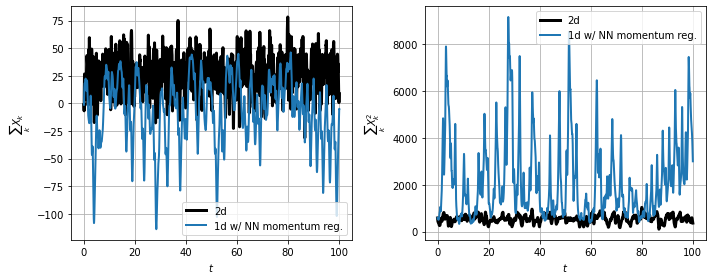

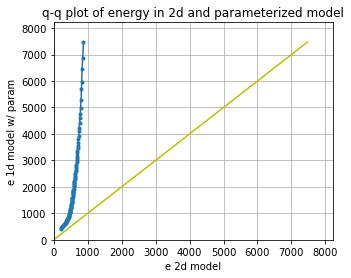

In [38]:
# Here it actually does an okay job of producing the F=20 simulation

gcm_nn3_x10 = GCM_network(Forcing_x10, nn_3l_loss3)
xnn3_x10, tnn3_x10 = gcm_nn3_x10(init_cond, dt, int(T / (dt)), nn_3l_loss3)

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn3_x10, xnn3_x10, "1d w/ NN momentum reg."],
    ],
)

# Try a different scaling term

Could scaling with the Forcing be the issue?

In [39]:
# Use the advection tendencies, splitting into 80% training and 20% testing.

L = int(len(X) * 0.8)
print(L)

ScX = np.sqrt(np.mean(X**2))
X_S = X_x10 / ScX
ScA = np.sqrt(np.mean(Adv**2))
Adv_S = Adv_x10 / ScA

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[:L])).double(),
    torch.from_numpy(np.array(Adv_S[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[L:])).double(),
    torch.from_numpy(np.array(Adv_S[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

40000


train loss: 2.6328390920132447
validation loss: 2.6623849972105873
train loss: 1.633248641046551
validation loss: 1.698642336907066
train loss: 1.3585074094818201
validation loss: 1.4188325044480108
train loss: 1.3008246120071505
validation loss: 1.3781783407357107
train loss: 1.0774138680738998
validation loss: 1.1540435121412596
train loss: 1.0565355080372818
validation loss: 1.1428874944120193
train loss: 1.009691592890713
validation loss: 1.1018298691165618
train loss: 1.052913319259672
validation loss: 1.124510752004196
train loss: 0.9576572804146009
validation loss: 1.0308848726164448
train loss: 0.8820146591181596
validation loss: 0.9683657146789126
train loss: 0.870793883931278
validation loss: 0.9575478644278365
train loss: 0.8947501801576244
validation loss: 0.9900642072996796
train loss: 0.8615280671365075
validation loss: 0.9458599174114246
train loss: 0.8213204566422572
validation loss: 0.9073013654569934
train loss: 0.8793751746983295
validation loss: 0.950746778138152
tr

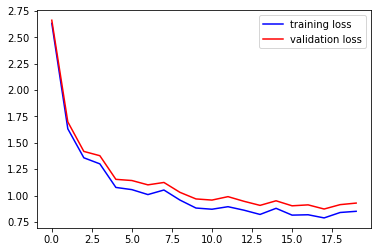

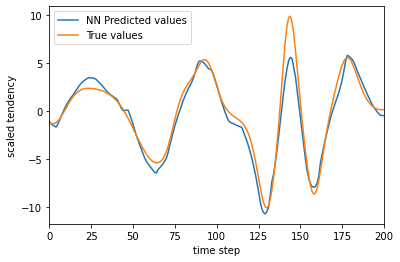

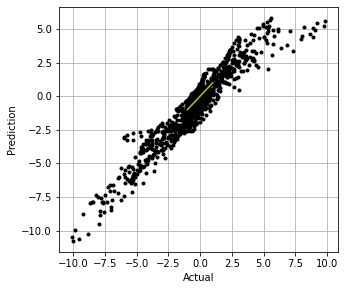

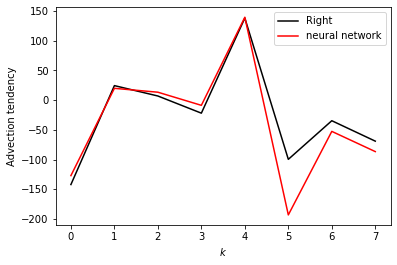

In [40]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss4 = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_loss4.parameters(), lr=0.03, weight_decay=0.001)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_loss4, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_loss4, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_loss4, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend()

# Look how network does for the tendencies

preds22 = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_S[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_S[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss4(torch.from_numpy(np.array(Xt / ScX)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * ScA, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

In [41]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network_S:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / ScX).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / ScX, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + ScA * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

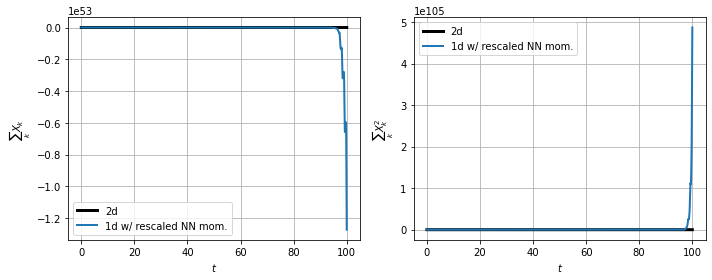

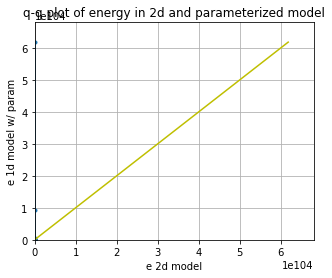

In [42]:
# Usually the network this produces works okay w/ F=10

gcm_nn4 = GCM_network_S(Forcing, nn_3l_loss4)
xnn4, tnn4 = gcm_nn4(init_cond, dt, int(T / dt), nn_3l_loss4)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn4, xnn4, "1d w/ rescaled NN mom."],
    ],
)

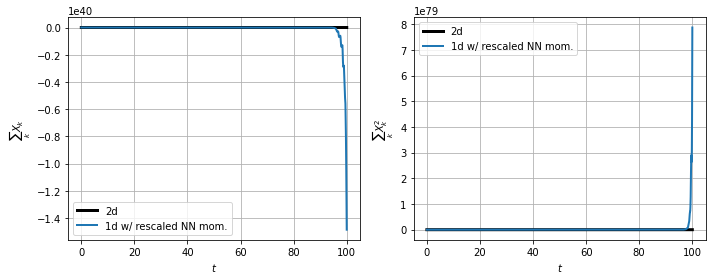

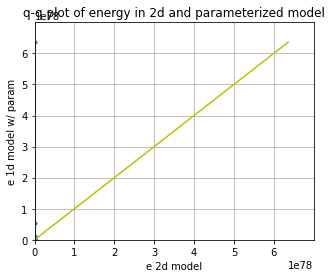

In [43]:
# This might work well for F=20

gcm_nn4_x10 = GCM_network_S(Forcing_x10, nn_3l_loss4)
xnn4_x10, tnn4_x10 = gcm_nn4_x10(init_cond, dt, int(T / dt), nn_3l_loss4)


CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn4_x10, xnn4_x10, "1d w/ rescaled NN mom."],
    ],
)

# The actual conservation law should be for "energy"

Does this stabilize the model?

In [44]:
def my_loss3(inpt, output, target):
    # In which we replace conservation of "momentum" with conservation of "energy"
    loss = torch.mean(2 * (output - target) ** 2) + WT * torch.mean(
        torch.sum(inpt * output, axis=1) ** 2
    )
    return loss

train loss: 10.96170710906865
validation loss: 10.726555211002532
train loss: 9.055340440538801
validation loss: 8.952638348056018
train loss: 8.224261019297563
validation loss: 8.178702447537452
train loss: 7.655514220587703
validation loss: 7.68345216479977
train loss: 7.175495682320365
validation loss: 7.142122878417922
train loss: 7.161227927781785
validation loss: 7.234328788082722
train loss: 6.723444944980289
validation loss: 6.780163207351052
train loss: 6.742393364763674
validation loss: 6.8235942072758204
train loss: 6.480685285638129
validation loss: 6.573927466837693
train loss: 6.419310479595429
validation loss: 6.594754561406832
train loss: 6.278532522046247
validation loss: 6.481942807381207
train loss: 6.410992384850411
validation loss: 6.598489111368042
train loss: 6.502445678958127
validation loss: 6.638949449524821
train loss: 5.932270096537852
validation loss: 6.03461973617169
train loss: 5.922579847828716
validation loss: 6.120433569447872
train loss: 6.25916994682

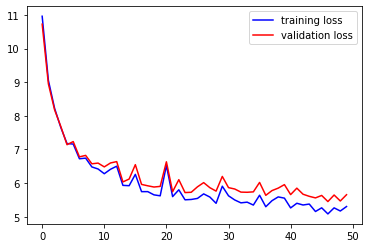

In [45]:
WT = 1

torch.manual_seed(14)  # For reproducibility
nn_3l_loss5 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss5.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss5, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss5, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss5, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

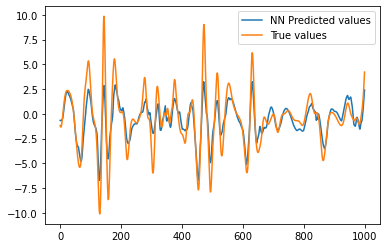

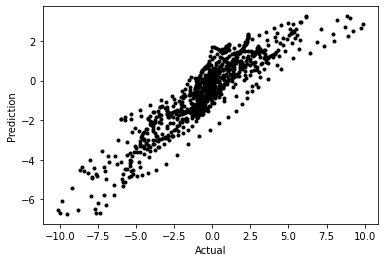

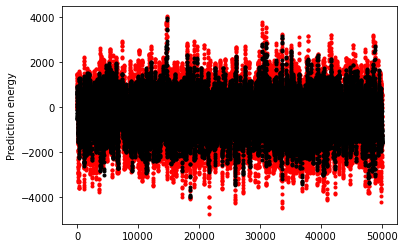

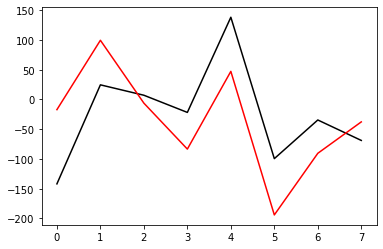

In [46]:
preds22o = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_S[:1000, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy() * ScA, axis=1), "r.")
plt.plot(np.sum(X * preds22.detach().numpy() * ScA, axis=1), "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss5(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

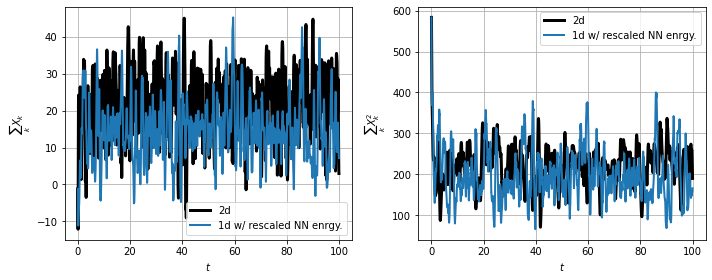

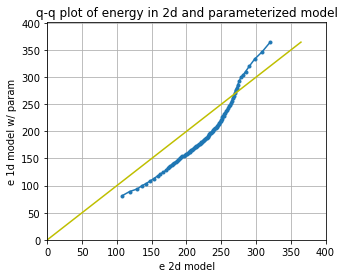

In [47]:
gcm_nn5 = GCM_network_S(Forcing, nn_3l_loss5)
xnn5, tnn5 = gcm_nn5(init_cond, dt, int(T / dt), nn_3l_loss5)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn5, xnn5, "1d w/ rescaled NN enrgy."],
    ],
)

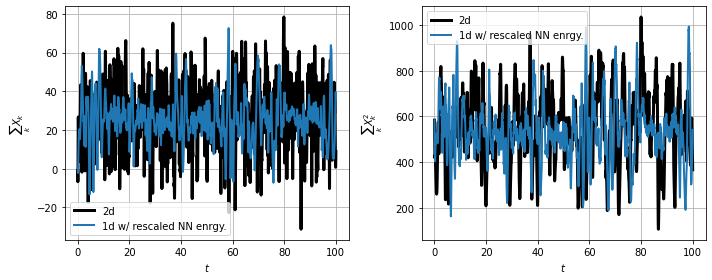

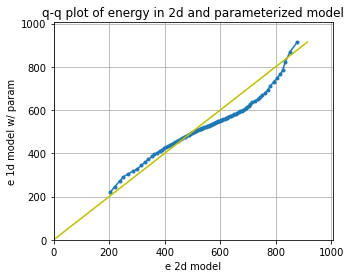

In [48]:
gcm_nn5_x10 = GCM_network_S(Forcing_x10, nn_3l_loss5)
xnn5_x10, tnn5_x10 = gcm_nn5_x10(init_cond, dt, int(T / dt), nn_3l_loss5)


CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn5_x10, xnn5_x10, "1d w/ rescaled NN enrgy."],
    ],
)

train loss: 13.78367463192507
validation loss: 13.439135580424146
train loss: 13.649474044440762
validation loss: 13.302679785472346
train loss: 13.682818308296538
validation loss: 13.245133617487971
train loss: 13.564646830315834
validation loss: 13.22279025967463
train loss: 13.620813440261022
validation loss: 13.227893961402396
train loss: 13.57465290840372
validation loss: 13.213247934151955
train loss: 13.526154091591701
validation loss: 13.168142368831132
train loss: 13.50611092797541
validation loss: 13.134767653524076
train loss: 13.404912629496147
validation loss: 13.04153448004431
train loss: 13.306312556050703
validation loss: 12.95228649059876
train loss: 13.074655167159895
validation loss: 12.711951698661595
train loss: 14.753705578563688
validation loss: 14.222969123072648
train loss: 12.757146001445424
validation loss: 12.388014085679906
train loss: 12.826021337493433
validation loss: 12.465770274151005
train loss: 13.157393905311196
validation loss: 12.835836513056819
t

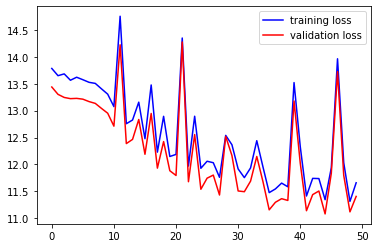

In [49]:
# Try with a higher weight?

WT = 50

torch.manual_seed(14)  # For reproducibility
nn_3l_loss6 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss6.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss6, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss6, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss6, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

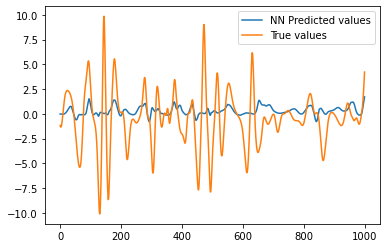

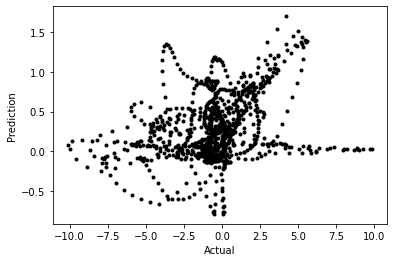

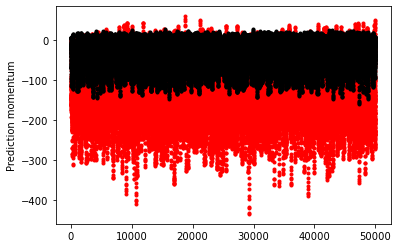

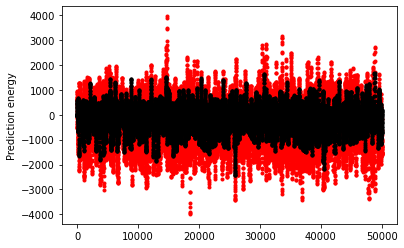

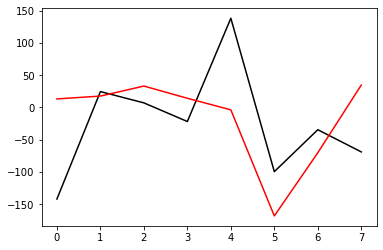

In [50]:
preds22o = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss6(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_S[:1000, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(X * preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss6(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [51]:
gcm_nn6 = GCM_network_S(Forcing, nn_3l_loss6)
xnn6, tnn6 = gcm_nn6(init_cond, dt, int(T / dt), nn_3l_loss6)

gcm_nn6_x10 = GCM_network_S(Forcing_x10, nn_3l_loss6)
xnn6_x10, tnn6_x10 = gcm_nn6_x10(init_cond, dt, int(T / dt), nn_3l_loss6)

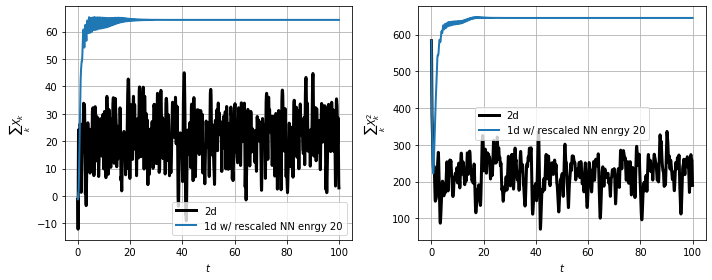

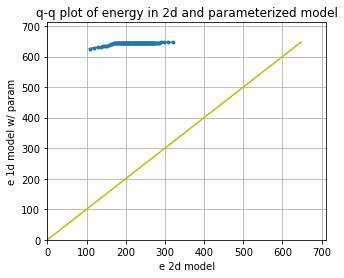

In [52]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn6, xnn6, "1d w/ rescaled NN enrgy 20"],
    ],
)

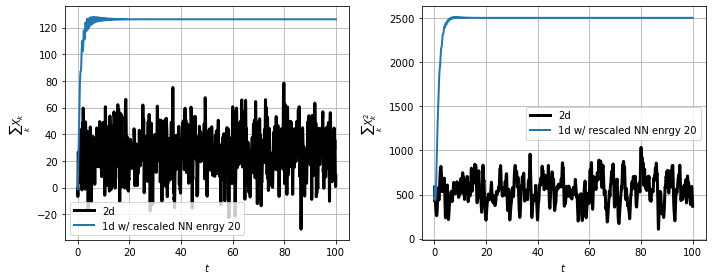

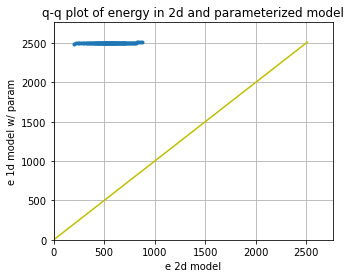

In [53]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn6_x10, xnn6_x10, "1d w/ rescaled NN enrgy 20"],
    ],
)

# NN inside of time-stepping algorithm

One issue may be that the network is applied as a forward Euler step.
Let's try moving the network inside the RHS that is passed to the RK4 algorithm

In [54]:
import torch


def L96_eq1_xdot_NN(X, F, NN, advect=True):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 1:
        d/dt X[k] = -X[k-2] X[k-1] + X[k-1] X[k+1] - X[k] + F

    Args:
        X : Values of X variables at the current time step
        F : Forcing term
    Returns:
        dXdt : Array of X time tendencies
    """

    K = len(X)
    Xdot = np.zeros(K)
    if NN.linear1.in_features == 1:
        X_torch = torch.from_numpy(X / ScX).double()
        X_torch = torch.unsqueeze(X_torch, 1)
    else:
        X_torch = torch.from_numpy(np.expand_dims(X / ScX, 0)).double()

    if advect:
        Xdot = np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) - X + F
    else:
        Xdot = -X + F + ScA * np.squeeze(NN(X_torch).data.numpy())
    #     for k in range(K):
    #         Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F
    return Xdot


# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network_tsNN:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot_NN(
            X, self.F, self.network, advect=False
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

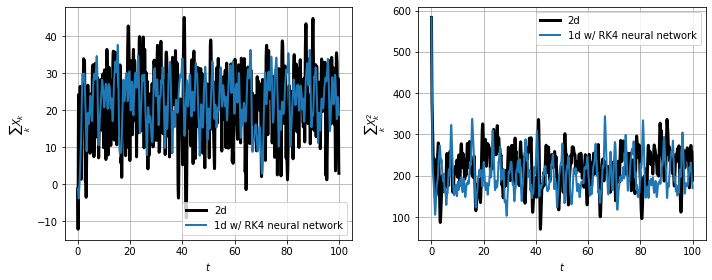

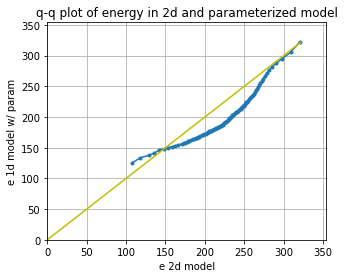

In [56]:
# Run a test with the parameterization

gcm_nnRK = GCM_network_tsNN(Forcing, nn_3l_x10, time_stepping=RK4)
xnnRK, tnnRK = gcm_nnRK(init_cond, dt, int(100 / (dt)), nn_3l)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnnRK, xnnRK, "1d w/ RK4 neural network"],
    ],
)

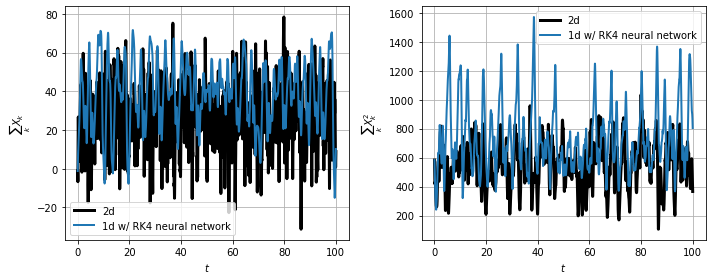

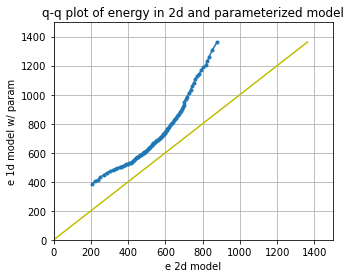

In [57]:
# Run a test with the parameterization

gcm_nnRK_x10 = GCM_network_tsNN(Forcing_x10, nn_3l_x10, time_stepping=RK4)
xnnRK_x10, tnnRK_x10 = gcm_nnRK_x10(init_cond, dt, int(100 / (dt)), nn_3l)

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnnRK_x10, xnnRK_x10, "1d w/ RK4 neural network"],
    ],
)

# Conclusions

- Conservation properties can be added to the loss function, but may not improve stability.
  - Conservation can unintentially over-regulate a network.
- Training a network for a wider parameter space than the model sees can help with stability.
  - Training with F=20 helps F=10 stay stable
  - Training for too broad of a parameter space may limit model ability to capture complex behavior (not shown, with F=100 tuning)
- Careful scaling is needed to help extrapolate results across parameter space. 
  - It was wrong to scale with forcing, scaling from the mean helps.  
  
  
  
- We could also consider more stability approaches, for example:
  - How you build the parameterization matters.  Building a parameterization for a flux instead of a flux tendency can help avoid non-conservation (not as applicable to our problem here, but seen in boundary layer parameterizations).
  - Coupled online learning can help tune networks that can learn evolving parameter spaces (see Rasp 2020 and their notebooks).
  